In [59]:
import numpy as np
import scipy as sc
from scipy import sparse
import random
import time
from scipy.special import expit, logsumexp
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

In [354]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%autoreload 2
import oracles, optimization2

In [7]:
# in oracles module:
#     class BinaryLogistic:
#         __init__(self, l2_coef)
#         func(self, X, y, w)
#         grad(self, X, y, w)
    
# in optimization module:
#     class GDClassifier:
#         __init__(self, loss_function, step_alpha=1, step_beta=0, 
#                  tolerance=1e-5, max_iter=1000, **kwargs)
#         fit(self, X, y, w_0=None, trace=False)
#         predict(self, X)
#         predict_proba(self, X)
#         get_objective(self, X, y)
#         get_gradient(self, X, y)
#         get_weights(self)
#         accuracy(self, X, y_true)
#     class SGDClassifier(GDClassifier):
#         __init__(self, loss_function, batch_size, step_alpha=1, step_beta=0, 
#                  tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs)
#         fit(self, X, y, w_0=None, trace=False, log_freq=1)

In [386]:
import pandas as pd
df_test1 = pd.read_csv('toxic_test.csv')
df_train1 = pd.read_csv('toxic_train.csv')

df_train1 = df_train1.drop(columns=['Unnamed: 0'])
df_test1 = df_test1.drop(columns=['Unnamed: 0'])

df_train1['comment_text'] = df_train1['comment_text'].str.lower()
df_test1['comment_text'] = df_test1['comment_text'].str.lower()

df_test1['comment_text'] = df_test1['comment_text'].str.replace(r'\W+', ' ')
df_train1['comment_text'] = df_train1['comment_text'].str.replace(r'\W+', ' ')

In [357]:
vectorizer = CountVectorizer(min_df=0.07, max_df=0.8)

x_train = vectorizer.fit_transform(df_train1['comment_text'])
x_test = vectorizer.transform(df_test1['comment_text'])

y_train = np.array([1 if ist else -1 for ist in df_train1['is_toxic']])
y_test = np.array([1 if ist else -1 for ist in df_test1['is_toxic']])

In [358]:
x_train.shape

(52061, 83)

In [103]:
import numpy as np
import scipy as sc
from scipy import sparse
import time
import random
import oracles


class GDClassifier:
    
    def __init__(self, loss_function, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, **kwargs):
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        if loss_function == 'binary_logistic':
            self.oracle = oracles.BinaryLogistic(l2_coef=kwargs['l2_coef'])
            
    def fit(self, X, y, w_0=None, trace=False, acc=False, x_test=None, y_test=None):
        
        if w_0 is None:
            self.w = np.zeros(X.shape[1])
        else:
            self.w = w_0.copy()
        hist = {'time': [0], 'func': [self.oracle.func(X, y, self.w)]}
        if acc:
            hist['acc'] = [self.accuracy(x_test, y_test)]
        start = time.time()        
        for k in range(1, self.max_iter + 1):
            if (k > 2) and abs(hist['func'][-2] - hist['func'][-1]) < self.tolerance:
                break
            self.w -= self.step_alpha / (k ** self.step_beta) * self.oracle.grad(X, y, self.w)
            hist['time'].append(time.time() - start)
            hist['func'].append(self.oracle.func(X, y, self.w))
            if acc:
                hist['acc'].append(self.accuracy(x_test, y_test))
            start = time.time()
        if trace:
            return hist
        
    def predict(self, X):
        return np.where((expit(X.dot(self.w)) >= 0.5) == True, 1, -1)

    def predict_proba(self, X):
        return expit(X.dot(self.w))
        
    def get_objective(self, X, y):
        pass
        
    def get_gradient(self, X, y):
        return self.oracle.grad(X, y, self.w)
    
    def get_weights(self):
        return self.w
    
    def accuracy(self, X_test, y_test):
        return (self.predict(X_test) == y_test).mean()


class SGDClassifier(GDClassifier):
    
    def __init__(self, loss_function, batch_size, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs):
        
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        if loss_function == 'binary_logistic':
            self.oracle = oracles.BinaryLogistic(l2_coef=kwargs['l2_coef'])
        self.rand_seed = random_seed
        self.batch_size = batch_size
        
    def fit(self, X, y, w_0=None, trace=False, log_freq=1, acc=False, x_test=None, y_test=None):

        np.random.seed(self.rand_seed)
        if w_0 is None:
            self.w = np.zeros(X.shape[1])
        else:
            self.w = w_0.copy()
        w_l = self.w.copy()
        used_obj_c = 0
        epoch_num = 0
        if trace:
            history = {'time': [0], 'func': [self.oracle.func(X, y, self.w)],
                       'weights_diff': [0], 'epoch_num' : [0]}
            if acc:
                history['acc'] = [self.accuracy(x_test, y_test)]
        start = time.time()
        for k in range(1, self.max_iter + 1):
            ind = np.random.randint(X.shape[0], size=self.batch_size)
            used_obj_c += self.batch_size
            epoch_num = used_obj_c / X.shape[0]
#             print(k, used_obj_c, epoch_num)
            if trace and (used_obj_c / X.shape[0] > log_freq):
                history['epoch_num'].append(epoch_num * len(history['epoch_num']))
                history['time'].append(time.time() - start)
                history['weights_diff'].append(((w_l - self.w) ** 2).sum())
                history['func'].append(self.oracle.func(X, y, self.w))
                if (k>2) and np.abs(history['func'][-2] - history['func'][-1]) < self.tolerance:
                    break
                if acc:
                    history['acc'].append(self.accuracy(x_test, y_test))
                w_l = self.w.copy()
                used_obj_c = 0
                start = time.time()
            self.w -= self.step_alpha / (k ** self.step_beta) * self.oracle.grad(X[ind], y[ind], self.w)

        if trace:
            return history

Wall time: 17min 17s


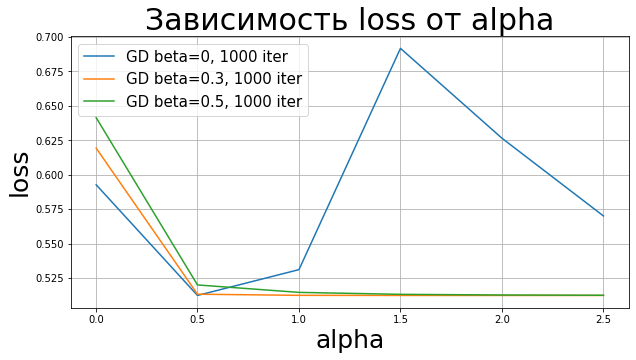

In [67]:
%%time

alps = [0.001, 0.5, 1, 1.5, 2, 2.5]

y_a_05 = []
y_a_3 = []
y_a_5 = []

# aca_05 = []
# aca_3 = []
# aca_5 = []

for al in alps:    
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=al,
                        step_beta=0.05, tolerance=0, max_iter=1000, batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test)
    y_a_05.append(history)
#     aca_05.append(clf.accuracy(x_test, y_test))
    
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=al,
                        step_beta=0.3, tolerance=0, max_iter=1000, batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test)
    y_a_3.append(history)
#     aca_3.append(clf.accuracy(x_test, y_test))
    
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=al,
                        step_beta=0.5, tolerance=0, max_iter=1000, batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test)
    y_a_5.append(history)
#     aca_5.append(clf.accuracy(x_test, y_test))

f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(alps, [i["func"][-1] for i in y_a_05], label="GD beta=0, 1000 iter")
ax.plot(alps, [i["func"][-1] for i in y_a_3], label="GD beta=0.3, 1000 iter")
ax.plot(alps, [i["func"][-1] for i in y_a_5], label="GD beta=0.5, 1000 iter")
ax.set_title("Зависимость loss от alpha", fontsize=30)
ax.set_xlabel(u"alpha", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("lossalpha2.pdf")

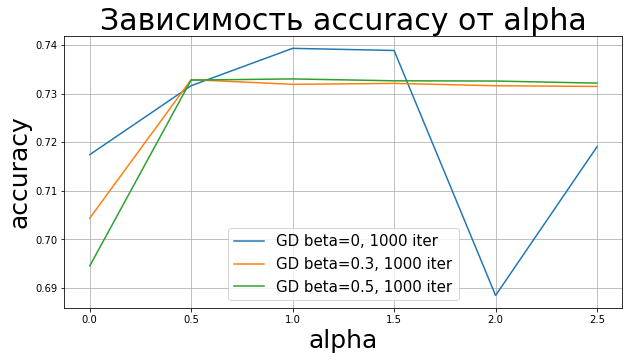

In [68]:
f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(alps, [i["acc"][-1] for i in y_a_05], label="GD beta=0, 1000 iter")
ax.plot(alps, [i["acc"][-1] for i in y_a_3], label="GD beta=0.3, 1000 iter")
ax.plot(alps, [i["acc"][-1] for i in y_a_5], label="GD beta=0.5, 1000 iter")
ax.set_title("Зависимость accuracy от alpha", fontsize=30)
ax.set_xlabel(u"alpha", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("accalpha2.pdf")

Wall time: 14min 17s


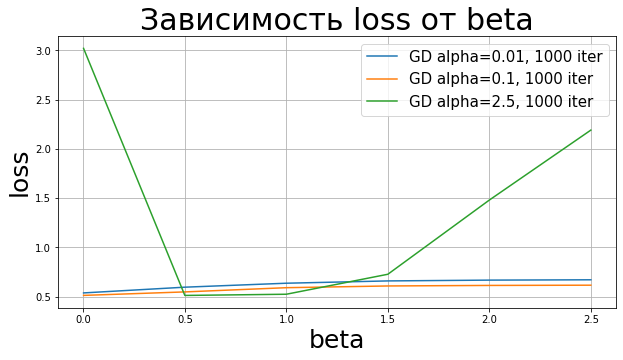

In [69]:
%%time

bets = [0, 0.5, 1, 1.5, 2, 2.5]

y_b_001 = []
y_b_01 = []
y_b_25 = []

# aca_05 = []
# aca_3 = []
# aca_5 = []

for be in alps:    
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.01,
                        step_beta=be, tolerance=0, max_iter=1000, batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test)
    y_b_001.append(history)
#     aca_05.append(clf.accuracy(x_test, y_test))
    
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.1,
                        step_beta=be, tolerance=0, max_iter=1000, batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test)
    y_b_01.append(history)
#     aca_3.append(clf.accuracy(x_test, y_test))
    
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=2.5,
                        step_beta=be, tolerance=0, max_iter=1000, batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test)
    y_b_25.append(history)
#     aca_5.append(clf.accuracy(x_test, y_test))

f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(alps, [i["func"][-1] for i in y_b_001], label="GD alpha=0.01, 1000 iter")
ax.plot(alps, [i["func"][-1] for i in y_b_01], label="GD alpha=0.1, 1000 iter")
ax.plot(alps, [i["func"][-1] for i in y_b_25], label="GD alpha=2.5, 1000 iter")
ax.set_title("Зависимость loss от beta", fontsize=30)
ax.set_xlabel(u"beta", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("lossbeta2.pdf")

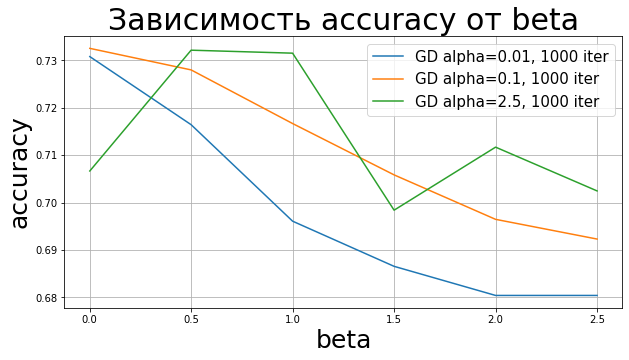

In [70]:
f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(alps, [i["acc"][-1] for i in y_b_001], label="GD alpha=0.01, 1000 iter")
ax.plot(alps, [i["acc"][-1] for i in y_b_01], label="GD alpha=0.1, 1000 iter")
ax.plot(alps, [i["acc"][-1] for i in y_b_25], label="GD alpha=2.5, 1000 iter")
ax.set_title("Зависимость accuracy от beta", fontsize=30)
ax.set_xlabel(u"beta", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("accbeta2.pdf")

## Самое интересное

Wall time: 2min 44s


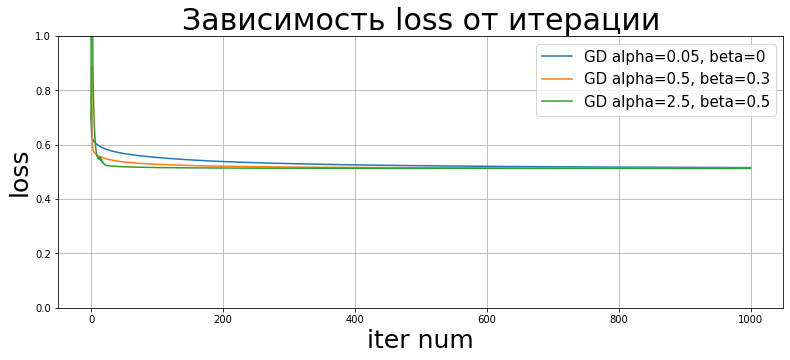

In [213]:
%%time

# aca_1 = []
# aca_2 = []
# aca_3 = []
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.05,
                    step_beta=0, tolerance=0, max_iter=1000, batch_size=5, l2_coef=0)
history_0 = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test)

clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
                    step_beta=0.3, tolerance=0, max_iter=1000, batch_size=5, l2_coef=0)
history_1 = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test)

clf = GDClassifier(loss_function='binary_logistic', step_alpha=2.5,
                    step_beta=0.5, tolerance=0, max_iter=1000, batch_size=5, l2_coef=0)
history_2 = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test)


f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(np.arange(0, len(history_0['time']))[:], history_0['func'][:], label="GD alpha=0.05, beta=0")
ax.plot(np.arange(0, len(history_1['time']))[:], history_1['func'][:], label="GD alpha=0.5, beta=0.3")
ax.plot(np.arange(0, len(history_2['time']))[:], history_2['func'][:], label="GD alpha=2.5, beta=0.5")
ax.set_title("Зависимость loss от итерации", fontsize=30)
ax.set_xlabel(u"iter num", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.set_ylim(0, 1)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("loss-iter-ab.pdf")

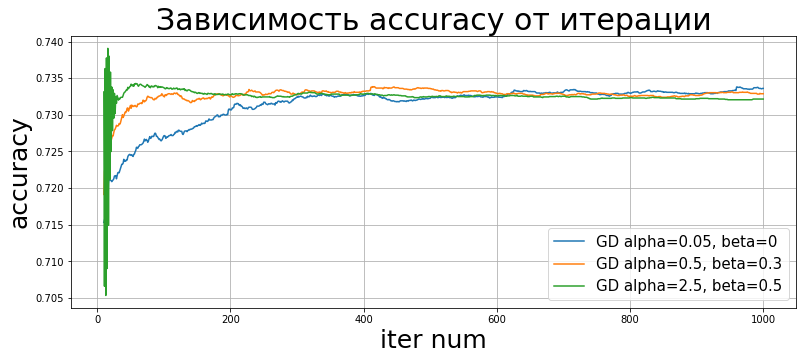

In [214]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(np.arange(0, len(history_0['time']))[10:], history_0['acc'][10:], label="GD alpha=0.05, beta=0")
ax.plot(np.arange(0, len(history_1['time']))[10:], history_1['acc'][10:], label="GD alpha=0.5, beta=0.3")
ax.plot(np.arange(0, len(history_2['time']))[10:], history_2['acc'][10:], label="GD alpha=2.5, beta=0.5")
ax.set_title("Зависимость accuracy от итерации", fontsize=30)
ax.set_xlabel(u"iter num", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
# ax.set_ylim(0, 1)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("acc-iter-ab.pdf")

In [215]:
history_0['time'] = np.array(history_0['time']).cumsum()
history_1['time'] = np.array(history_1['time']).cumsum()
history_2['time'] = np.array(history_2['time']).cumsum()

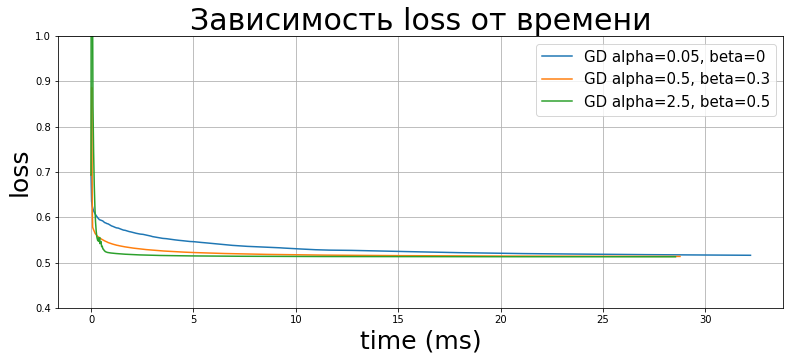

In [216]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['time'][:], history_0['func'][:], label="GD alpha=0.05, beta=0")
ax.plot(history_1['time'][:], history_1['func'][:], label="GD alpha=0.5, beta=0.3")
ax.plot(history_2['time'][:], history_2['func'][:], label="GD alpha=2.5, beta=0.5")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от времени", fontsize=30)
ax.set_xlabel(u"time (ms)", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.set_ylim(0.4, 1)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("loss-time-ab.pdf")

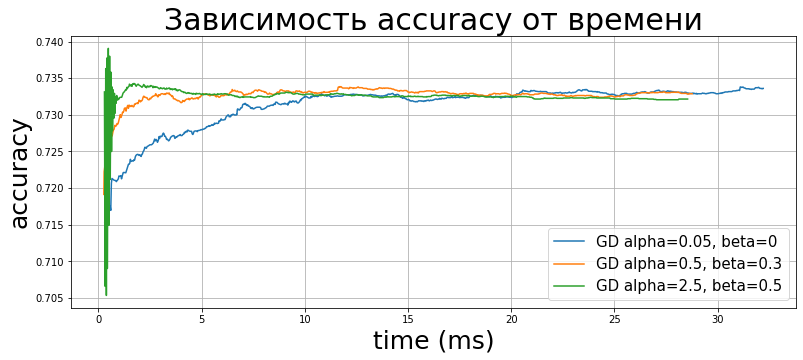

In [217]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['time'][10:], history_0['acc'][10:], label="GD alpha=0.05, beta=0")
ax.plot(history_1['time'][10:], history_1['acc'][10:], label="GD alpha=0.5, beta=0.3")
ax.plot(history_2['time'][10:], history_2['acc'][10:], label="GD alpha=2.5, beta=0.5")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость accuracy от времени", fontsize=30)
ax.set_xlabel(u"time (ms)", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
# ax.set_ylim(0, 1)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("acc-time-ab.pdf")

Wall time: 4min 37s


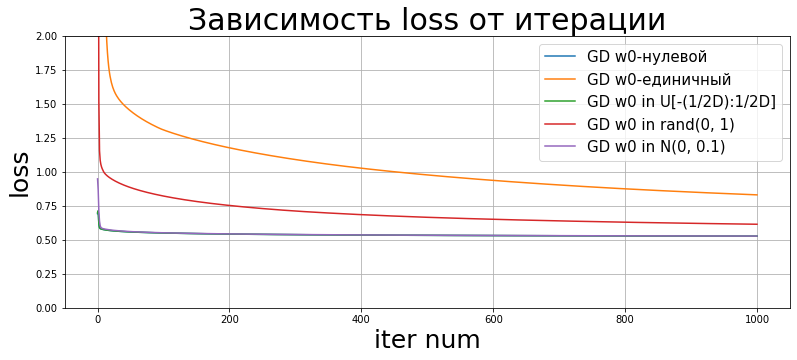

In [261]:
%%time

w_01 = np.ones(x_train.shape[1])
w_02 = np.random.uniform(-1/(2*x_train.shape[1]), 1/(2*x_train.shape[1]), size=x_train.shape[1])
w_03 = np.random.rand(x_train.shape[1])
w_04 = np.random.normal(0, 0.1, x_train.shape[1])

clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=1000, batch_size=100, l2_coef=0, iter_acc=True)
history_0 = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test)

clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=1000, batch_size=100, l2_coef=0, iter_acc=True)
history_1 = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test, w_0=w_01)

clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=1000, batch_size=100, l2_coef=0, iter_acc=True)
history_2 = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test, w_0=w_02)

clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=1000, batch_size=100, l2_coef=0, iter_acc=True)
history_3 = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test, w_0=w_03)

clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=1000, batch_size=100, l2_coef=0, iter_acc=True)
history_4 = clf.fit(x_train, y_train, trace=True, acc=True, x_test=x_test, y_test=y_test, w_0=w_04)

f, ax = plt.subplots(1, figsize=(13, 5))
# f.gca()
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(np.arange(0, len(history_0['time']))[:], history_0['func'][:], label="GD w0-нулевой")
ax.plot(np.arange(0, len(history_0['time']))[:], history_1['func'][:], label="GD w0-единичный")
ax.plot(np.arange(0, len(history_0['time']))[:], history_2['func'][:], label="GD w0 in U[-(1/2D):1/2D]")
ax.plot(np.arange(0, len(history_0['time']))[:], history_3['func'][:], label="GD w0 in rand(0, 1)")
ax.plot(np.arange(0, len(history_0['time']))[:], history_4['func'][:], label="GD w0 in N(0, 0.1)")
# ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от итерации", fontsize=30)
ax.set_xlabel(u"iter num", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.set_ylim(0, 2)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("loss-iter-w0.pdf")

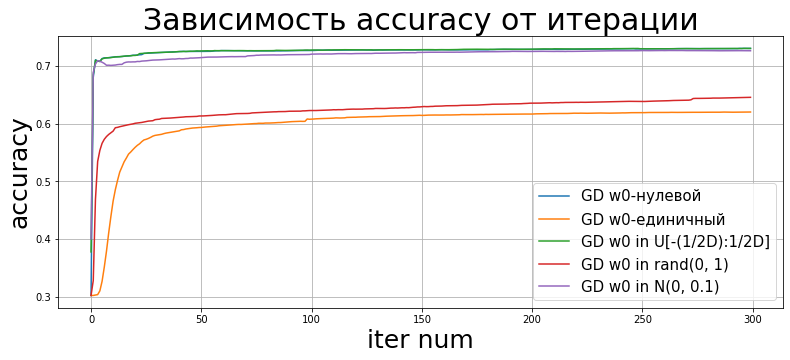

In [262]:
f, ax = plt.subplots(1, figsize=(13, 5))
# f.gca()
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(np.arange(0, len(history_0['time']))[:300], history_0['acc'][:300], label="GD w0-нулевой")
ax.plot(np.arange(0, len(history_0['time']))[:300], history_1['acc'][:300], label="GD w0-единичный")
ax.plot(np.arange(0, len(history_0['time']))[:300], history_2['acc'][:300], label="GD w0 in U[-(1/2D):1/2D]")
ax.plot(np.arange(0, len(history_0['time']))[:300], history_3['acc'][:300], label="GD w0 in rand(0, 1)")
ax.plot(np.arange(0, len(history_0['time']))[:300], history_4['acc'][:300], label="GD w0 in N(0, 0.1)")
# ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость accuracy от итерации", fontsize=30)
ax.set_xlabel(u"iter num", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
# ax.set_ylim(0, 2)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("acc-iter-w0.pdf")

In [263]:
history_0['time'] = np.array(history_0['time']).cumsum()
history_1['time'] = np.array(history_1['time']).cumsum()
history_2['time'] = np.array(history_2['time']).cumsum()

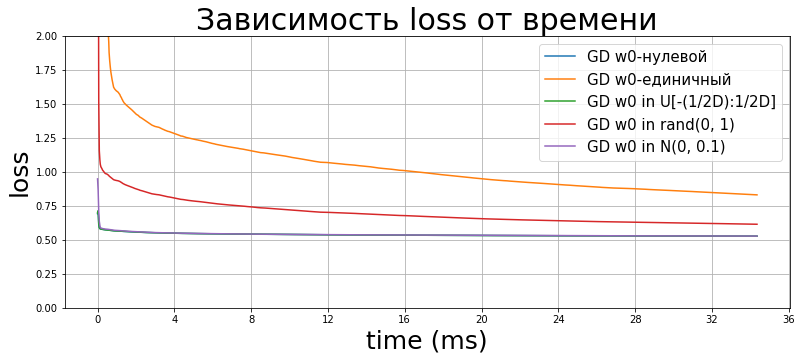

In [264]:
f, ax = plt.subplots(1, figsize=(13, 5))
# f.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_0['time'][:], history_0['func'][:], label="GD w0-нулевой")
ax.plot(history_0['time'][:], history_1['func'][:], label="GD w0-единичный")
ax.plot(history_0['time'][:], history_2['func'][:], label="GD w0 in U[-(1/2D):1/2D]")
ax.plot(history_0['time'][:], history_3['func'][:], label="GD w0 in rand(0, 1)")
ax.plot(history_0['time'][:], history_4['func'][:], label="GD w0 in N(0, 0.1)")
# ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от времени", fontsize=30)
ax.set_xlabel(u"time (ms)", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.set_ylim(0, 2)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("loss-time-w0.pdf")

In [259]:
len(history_0['time'])

1001

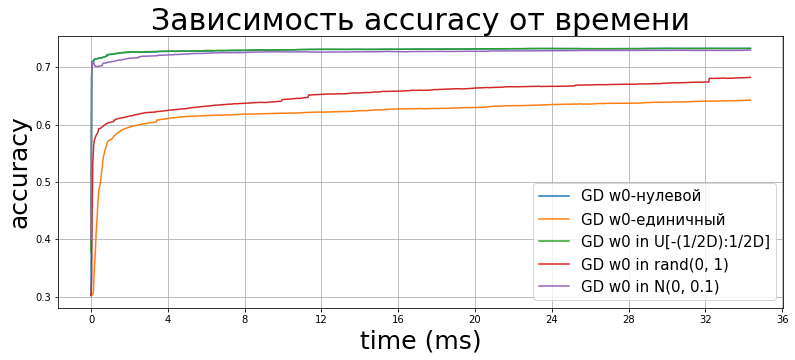

In [265]:
f, ax = plt.subplots(1, figsize=(13, 5))
# f.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_0['time'][:], history_0['acc'][:], label="GD w0-нулевой")
ax.plot(history_0['time'][:], history_1['acc'][:], label="GD w0-единичный")
ax.plot(history_0['time'][:], history_2['acc'][:], label="GD w0 in U[-(1/2D):1/2D]")
ax.plot(history_0['time'][:], history_3['acc'][:], label="GD w0 in rand(0, 1)")
ax.plot(history_0['time'][:], history_4['acc'][:], label="GD w0 in N(0, 0.1)")
# ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость accuracy от времени", fontsize=30)
ax.set_xlabel(u"time (ms)", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
# ax.set_ylim(0, 1)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("acc-time-w0.pdf")

## Стохастический(мини-батч) градиентный спуск

Wall time: 16.8 s


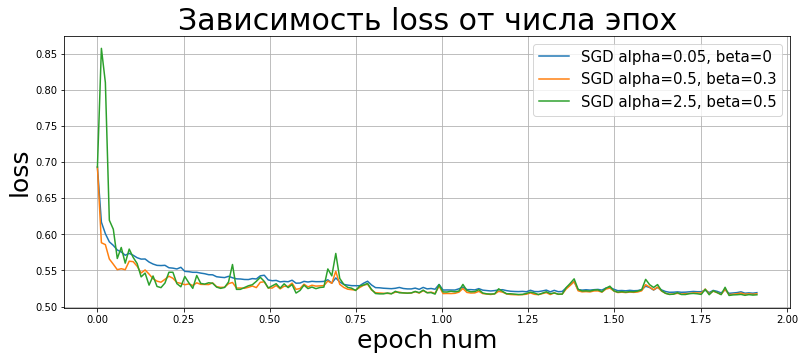

In [223]:
%%time

# aca_1 = []
# aca_2 = []
# aca_3 = []
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.05,
                    step_beta=0, tolerance=0, max_iter=1000, batch_size=100, l2_coef=0)
history_0 = clf.fit(x_train, y_train, trace=True, log_freq=0.01, acc=True, x_test=x_test, y_test=y_test)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5,
                    step_beta=0.3, tolerance=0, max_iter=1000, batch_size=100, l2_coef=0)
history_1 = clf.fit(x_train, y_train, trace=True, log_freq=0.01, acc=True, x_test=x_test, y_test=y_test)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=2.5,
                    step_beta=0.5, tolerance=0, max_iter=1000, batch_size=100, l2_coef=0)
history_2 = clf.fit(x_train, y_train, trace=True, log_freq=0.01, acc=True, x_test=x_test, y_test=y_test)


f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['epoch_num'], history_0['func'], label="SGD alpha=0.05, beta=0")
ax.plot(history_1['epoch_num'], history_1['func'], label="SGD alpha=0.5, beta=0.3")
ax.plot(history_2['epoch_num'], history_2['func'], label="SGD alpha=2.5, beta=0.5")
ax.set_title("Зависимость loss от числа эпох", fontsize=30)
ax.set_xlabel(u"epoch num", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
# ax.set_ylim(0, 1)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("s-loss-epoch-ab.pdf")

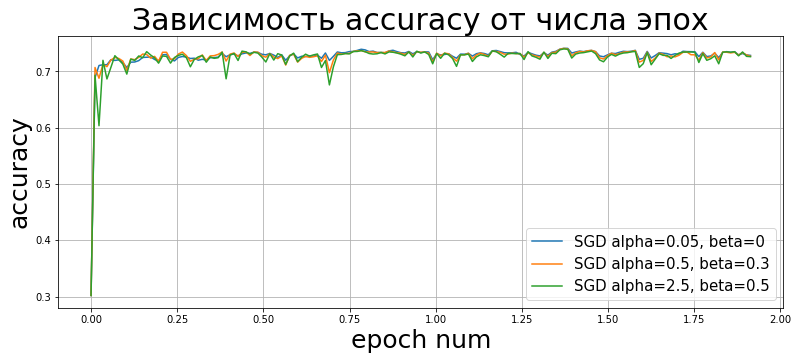

In [224]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['epoch_num'], history_0['acc'], label="SGD alpha=0.05, beta=0")
ax.plot(history_1['epoch_num'], history_1['acc'], label="SGD alpha=0.5, beta=0.3")
ax.plot(history_2['epoch_num'], history_2['acc'], label="SGD alpha=2.5, beta=0.5")
ax.set_title("Зависимость accuracy от числа эпох", fontsize=30)
ax.set_xlabel(u"epoch num", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
# ax.set_ylim(0, 1)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("s-acc-epoch-ab.pdf")

In [225]:
history_0['time'] = np.array(history_0['time']).cumsum()
history_1['time'] = np.array(history_1['time']).cumsum()
history_2['time'] = np.array(history_2['time']).cumsum()

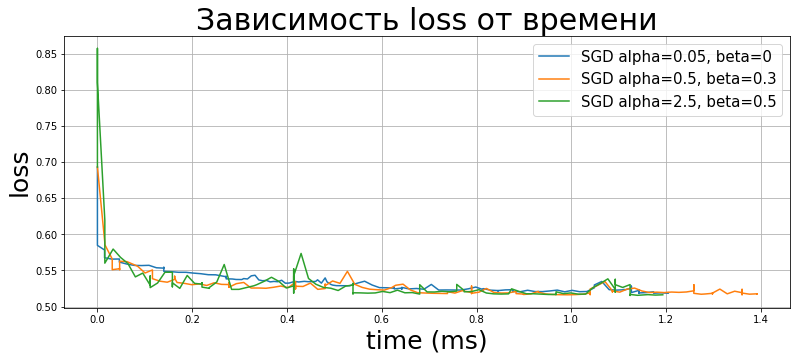

In [226]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['time'], history_0['func'], label="SGD alpha=0.05, beta=0")
ax.plot(history_1['time'], history_1['func'], label="SGD alpha=0.5, beta=0.3")
ax.plot(history_2['time'], history_2['func'], label="SGD alpha=2.5, beta=0.5")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от времени", fontsize=30)
ax.set_xlabel(u"time (ms)", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("s-loss-time-ab.pdf")

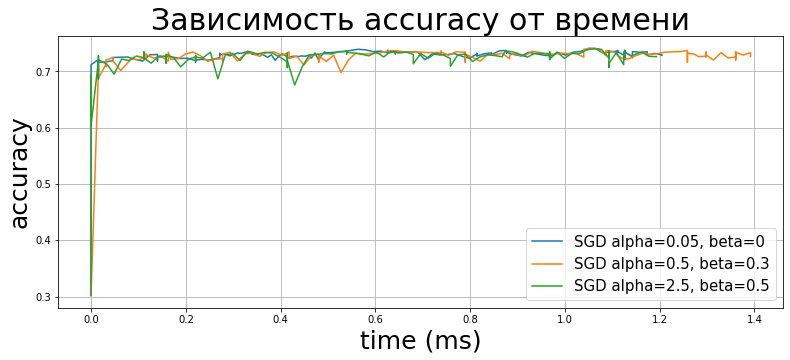

In [227]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['time'], history_0['acc'], label="SGD alpha=0.05, beta=0")
ax.plot(history_1['time'], history_1['acc'], label="SGD alpha=0.5, beta=0.3")
ax.plot(history_2['time'], history_2['acc'], label="SGD alpha=2.5, beta=0.5")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость accuracy от времени", fontsize=30)
ax.set_xlabel(u"time (ms)", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("s-acc-time-ab.pdf")

Wall time: 4min 17s


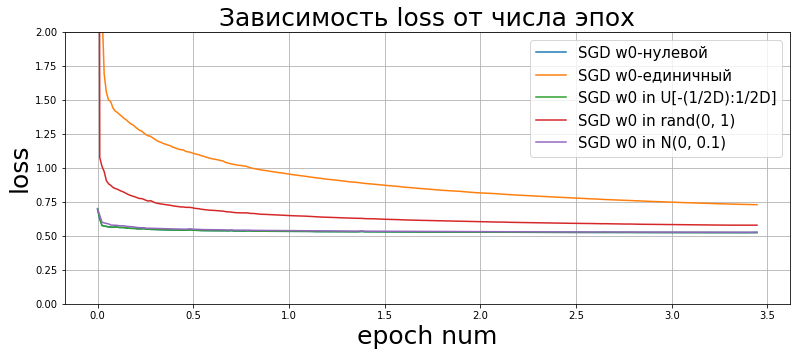

In [284]:
%%time

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# aca_1 = []
# aca_2 = []
# aca_3 = []
# aca_4 = []
# aca_5 = []
w_01 = np.ones(x_train.shape[1])
w_02 = np.random.uniform(-1/(2*x_train.shape[1]), 1/(2*x_train.shape[1]), size=x_train.shape[1])
w_03 = np.random.rand(x_train.shape[1])
w_04 = np.random.normal(0, 0.1, x_train.shape[1])

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=10000, batch_size=100, l2_coef=0, iter_acc=True)
history_0 = clf.fit(x_train, y_train, trace=True, log_freq=0.01, acc=True, x_test=x_test, y_test=y_test)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=10000, batch_size=100, l2_coef=0, iter_acc=True)
history_1 = clf.fit(x_train, y_train, trace=True, log_freq=0.01, acc=True, x_test=x_test, y_test=y_test, w_0=w_01)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=10000, batch_size=100, l2_coef=0, iter_acc=True)
history_2 = clf.fit(x_train, y_train, trace=True, log_freq=0.01, acc=True, x_test=x_test, y_test=y_test, w_0=w_02)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=10000, batch_size=100, l2_coef=0, iter_acc=True)
history_3 = clf.fit(x_train, y_train, trace=True, log_freq=0.01, acc=True, x_test=x_test, y_test=y_test, w_0=w_03)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=10000, batch_size=100, l2_coef=0, iter_acc=True)
history_4 = clf.fit(x_train, y_train, trace=True, log_freq=0.01, acc=True, x_test=x_test, y_test=y_test, w_0=w_04)

f, ax = plt.subplots(1, figsize=(13, 5))
# f.gca()
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_0['epoch_num'][:300], history_0['func'][:300], label="SGD w0-нулевой")
ax.plot(history_1['epoch_num'][:300], history_1['func'][:300], label="SGD w0-единичный")
ax.plot(history_2['epoch_num'][:300], history_2['func'][:300], label="SGD w0 in U[-(1/2D):1/2D]")
ax.plot(history_3['epoch_num'][:300], history_3['func'][:300], label="SGD w0 in rand(0, 1)")
ax.plot(history_4['epoch_num'][:300], history_4['func'][:300], label="SGD w0 in N(0, 0.1)")
# ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от числа эпох", fontsize=25)
ax.set_xlabel(u"epoch num", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.set_ylim(0, 2)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("s-loss-epoch-w0.pdf")

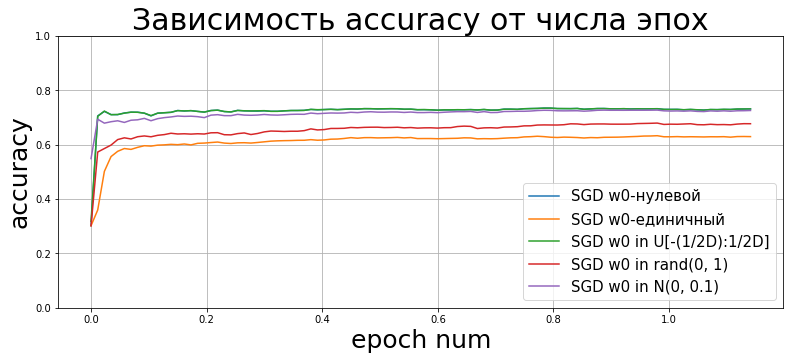

In [274]:
f, ax = plt.subplots(1, figsize=(13, 5))
# f.gca()
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_0['epoch_num'][:100], history_0['acc'][:100], label="SGD w0-нулевой")
ax.plot(history_1['epoch_num'][:100], history_1['acc'][:100], label="SGD w0-единичный")
ax.plot(history_2['epoch_num'][:100], history_2['acc'][:100], label="SGD w0 in U[-(1/2D):1/2D]")
ax.plot(history_3['epoch_num'][:100], history_3['acc'][:100], label="SGD w0 in rand(0, 1)")
ax.plot(history_4['epoch_num'][:100], history_4['acc'][:100], label="SGD w0 in N(0, 0.1)")
# ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость accuracy от числа эпох", fontsize=30)
ax.set_xlabel(u"epoch num", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
ax.set_ylim(0, 1)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("s-acc-epoch-w0.pdf")

In [275]:
history_0['time'] = np.array(history_0['time']).cumsum()
history_1['time'] = np.array(history_1['time']).cumsum()
history_2['time'] = np.array(history_2['time']).cumsum()
history_3['time'] = np.array(history_3['time']).cumsum()
history_4['time'] = np.array(history_4['time']).cumsum()

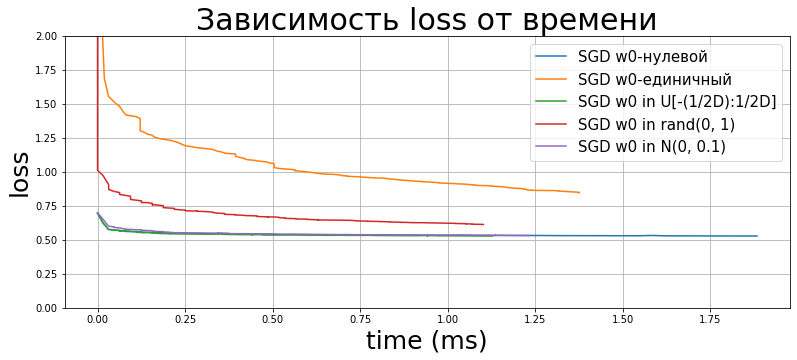

In [279]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['time'][:150], history_0['func'][:150], label="SGD w0-нулевой")
ax.plot(history_1['time'][:150], history_1['func'][:150], label="SGD w0-единичный")
ax.plot(history_2['time'][:150], history_2['func'][:150], label="SGD w0 in U[-(1/2D):1/2D]")
ax.plot(history_3['time'][:150], history_3['func'][:150], label="SGD w0 in rand(0, 1)")
ax.plot(history_4['time'][:150], history_4['func'][:150], label="SGD w0 in N(0, 0.1)")
#ax2.plot(x, y2s, label="sgd")
ax.set_ylim(0, 2)
ax.set_title("Зависимость loss от времени", fontsize=30)
ax.set_xlabel(u"time (ms)", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("s-loss-time-w0.pdf")

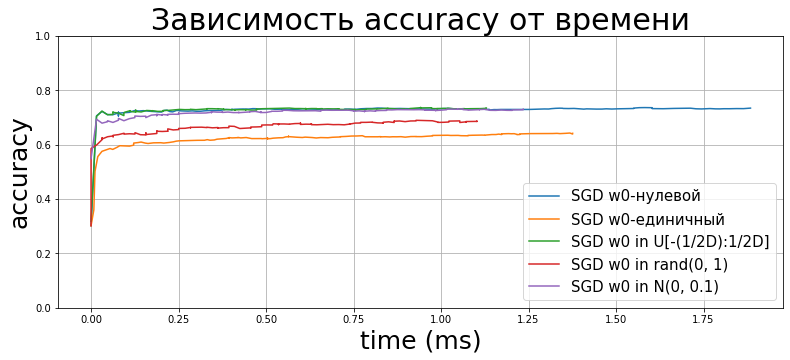

In [280]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['time'][:150], history_0['acc'][:150], label="SGD w0-нулевой")
ax.plot(history_1['time'][:150], history_1['acc'][:150], label="SGD w0-единичный")
ax.plot(history_2['time'][:150], history_2['acc'][:150], label="SGD w0 in U[-(1/2D):1/2D]")
ax.plot(history_3['time'][:150], history_3['acc'][:150], label="SGD w0 in rand(0, 1)")
ax.plot(history_4['time'][:150], history_4['acc'][:150], label="SGD w0 in N(0, 0.1)")
#ax2.plot(x, y2s, label="sgd")
ax.set_ylim(0, 1)
ax.set_title("Зависимость accuracy от времени", fontsize=30)
ax.set_xlabel(u"time (ms)", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("s-acc-time-w0.pdf")

In [233]:
len(history_3['epoch_num'])

1667

Wall time: 23.3 s


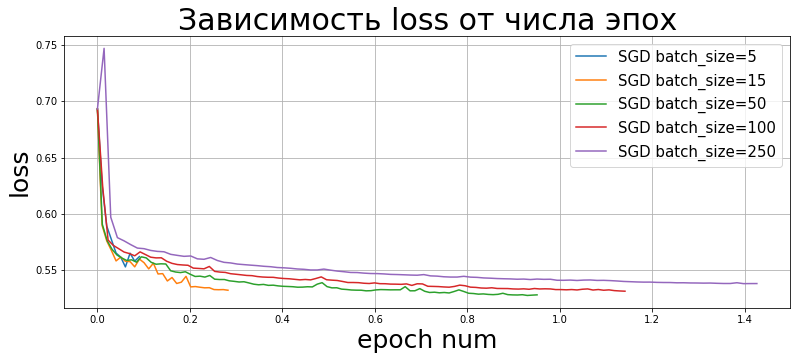

In [282]:
%%time

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=1000, batch_size=5, l2_coef=0, iter_acc=True)
history_0 = clf.fit(x_train, y_train, trace=True, log_freq=0.01, acc=True, x_test=x_test, y_test=y_test)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=1000, batch_size=15, l2_coef=0, iter_acc=True)
history_1 = clf.fit(x_train, y_train, trace=True, log_freq=0.01, acc=True, x_test=x_test, y_test=y_test)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=1000, batch_size=50, l2_coef=0, iter_acc=True)
history_2 = clf.fit(x_train, y_train, trace=True, log_freq=0.01, acc=True, x_test=x_test, y_test=y_test)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=1000, batch_size=100, l2_coef=0, iter_acc=True)
history_3 = clf.fit(x_train, y_train, trace=True, log_freq=0.01, acc=True, x_test=x_test, y_test=y_test)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=1000, batch_size=250, l2_coef=0, iter_acc=True)
history_4 = clf.fit(x_train, y_train, trace=True, log_freq=0.01, acc=True, x_test=x_test, y_test=y_test)

f, ax = plt.subplots(1, figsize=(13, 5))
# f.gca()
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_0['epoch_num'][:100], history_0['func'][:100], label="SGD batch_size=5")
ax.plot(history_1['epoch_num'][:100], history_1['func'][:100], label="SGD batch_size=15")
ax.plot(history_2['epoch_num'][:100], history_2['func'][:100], label="SGD batch_size=50")
ax.plot(history_3['epoch_num'][:100], history_3['func'][:100], label="SGD batch_size=100")
ax.plot(history_4['epoch_num'][:100], history_4['func'][:100], label="SGD batch_size=250")
# ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от числа эпох", fontsize=30)
ax.set_xlabel(u"epoch num", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
# ax.set_ylim(0, 1)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("s-loss-epoch-batch.pdf")

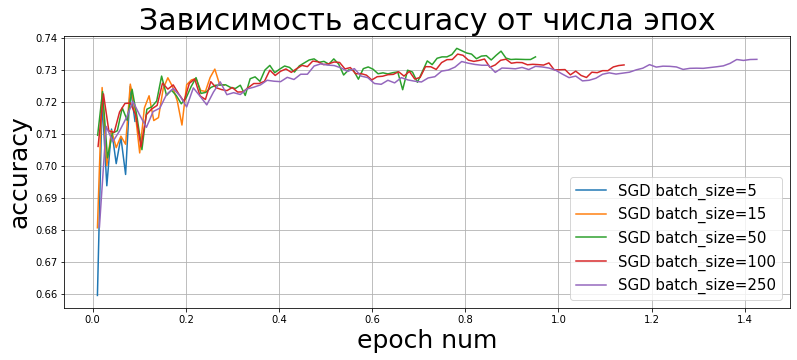

In [283]:
f, ax = plt.subplots(1, figsize=(13, 5))
# f.gca()
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_0['epoch_num'][1:], history_0['acc'][1:], label="SGD batch_size=5")
ax.plot(history_1['epoch_num'][1:], history_1['acc'][1:], label="SGD batch_size=15")
ax.plot(history_2['epoch_num'][1:], history_2['acc'][1:], label="SGD batch_size=50")
ax.plot(history_3['epoch_num'][1:100], history_3['acc'][1:100], label="SGD batch_size=100")
ax.plot(history_4['epoch_num'][1:100], history_4['acc'][1:100], label="SGD batch_size=250")
# ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость accuracy от числа эпох", fontsize=30)
ax.set_xlabel(u"epoch num", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
# ax.set_ylim(0, 1)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("s-acc-epoch-batch.pdf")

In [268]:
history_0['time'] = np.array(history_0['time']).cumsum()
history_1['time'] = np.array(history_1['time']).cumsum()
history_2['time'] = np.array(history_2['time']).cumsum()
history_3['time'] = np.array(history_3['time']).cumsum()
history_4['time'] = np.array(history_4['time']).cumsum()

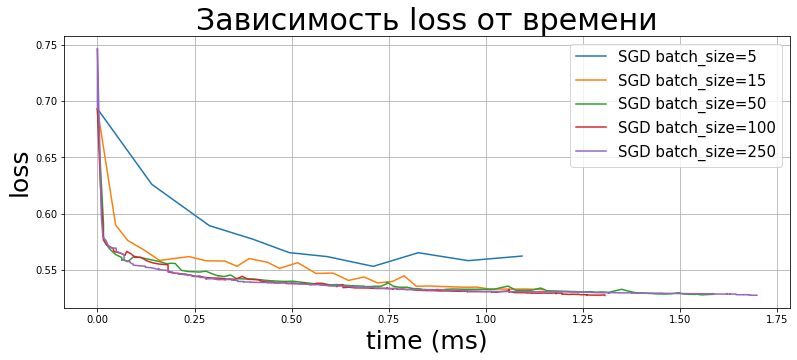

In [272]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['time'], history_0['func'], label="SGD batch_size=5")
ax.plot(history_1['time'], history_1['func'], label="SGD batch_size=15")
ax.plot(history_2['time'], history_2['func'], label="SGD batch_size=50")
ax.plot(history_3['time'], history_3['func'], label="SGD batch_size=100")
ax.plot(history_4['time'], history_4['func'], label="SGD batch_size=250")
#ax2.plot(x, y2s, label="sgd")
# ax.set_ylim(0, 2)
ax.set_title("Зависимость loss от времени", fontsize=30)
ax.set_xlabel(u"time (ms)", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("s-loss-time-batch.pdf")

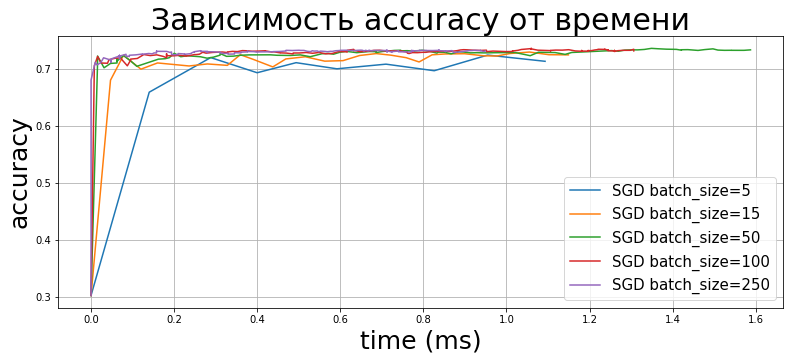

In [270]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['time'], history_0['acc'], label="SGD batch_size=5")
ax.plot(history_1['time'], history_1['acc'], label="SGD batch_size=15")
ax.plot(history_2['time'], history_2['acc'], label="SGD batch_size=50")
ax.plot(history_3['time'], history_3['acc'], label="SGD batch_size=100")
ax.plot(history_4['time'][:200], history_4['acc'][:200], label="SGD batch_size=250")
#ax2.plot(x, y2s, label="sgd")
# ax.set_ylim(0, 1)
ax.set_title("Зависимость accuracy от времени", fontsize=30)
ax.set_xlabel(u"time (ms)", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("s-acc-time-batch.pdf")

In [285]:
import nltk

In [323]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Екатерина\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Екатерина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Екатерина\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [287]:
import nltk
from nltk.stem import WordNetLemmatizer 
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
# Lemmatize Single Word
print(lemmatizer.lemmatize("bats"))
#> bat
print(lemmatizer.lemmatize("are"))
#> are
print(lemmatizer.lemmatize("feet"))

bat
are
foot


In [291]:
sentence = "The striped bats are hanging on their feet for best"
word_list = nltk.word_tokenize(sentence)
print(word_list)
lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
print(lemmatized_output)

['The', 'striped', 'bats', 'are', 'hanging', 'on', 'their', 'feet', 'for', 'best']
The striped bat are hanging on their foot for best


In [319]:
df_test1['comment_text'][0]

'thank you for understanding i think very highly of you and would not revert without discussion '

In [320]:
' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(df_test1['comment_text'][0])])

'thank you for understanding i think very highly of you and would not revert without discussion'

In [369]:
lem_test1 = pd.read_csv('toxic_test.csv')
lem_train1 = pd.read_csv('toxic_train.csv')

# lem_train1 = df_train1.drop(columns=['Unnamed: 0'])
# lem_test1 = df_test1.drop(columns=['Unnamed: 0'])

lem_train1['comment_text'] = df_train1['comment_text'].str.lower()
lem_test1['comment_text'] = df_test1['comment_text'].str.lower()

lem_test1['comment_text'] = df_test1['comment_text'].str.replace(r'\W+', ' ')
lem_train1['comment_text'] = df_train1['comment_text'].str.replace(r'\W+', ' ')

In [ ]:
word_list = ' '.join([word for word in nltk.word_tokenize(df_test1['comment_text'][4])
             if word not in set(stopwords.words('english'))])

In [ ]:
vectorizer = CountVectorizer(min_df=0.07, max_df=0.8)
x_test = vectorizer.transform(df_test1['comment_text'])

In [ ]:
x_test.shape

In [390]:
len(list(stopwords.words('english')))

179

In [310]:
word_list = nltk.word_tokenize(df_test1['comment_text'][2352])

In [345]:
# import nltk
from nltk.corpus import stopwords
# set(stopwords.words('english'))

In [340]:
# %%timeit
word_list = ' '.join([word for word in nltk.word_tokenize(df_test1['comment_text'][4])
             if word not in set(stopwords.words('english'))])

In [341]:
df_test1['comment_text'][4]

' before adding a new product to the list make sure it s relevant before adding a new product to the list make sure it has a wikipedia entry already proving it s relevance and giving the reader the possibility to read more about it otherwise it could be subject to deletion see this article s revision history '

In [342]:
word_list

'adding new product list make sure relevant adding new product list make sure wikipedia entry already proving relevance giving reader possibility read otherwise could subject deletion see article revision history'

In [343]:
lem_test1['comment_text'][4]

'" \n\n == Before adding a new product to the list, make sure it\'s relevant == \n\n Before adding a new product to the list, make sure it has a wikipedia entry already, ""proving"" it\'s relevance and giving the reader the possibility to read more about it. \n Otherwise it could be subject to deletion. See this article\'s revision history."'

In [362]:
df_train1['comment_text'][9]

'alignment on this subject and which are contrary to those of dulithgow'

In [363]:
lem_train1['comment_text'][9]

'alignment on this subject and which are contrary to those of DuLithgow'

In [370]:
lem_test1['comment_text'][317]

' french revolution causes 1 old regime the three estates first estate church owned 10 percent land paid 2 percent in taxes second estate nobles owned 20 percent of land and paid 1 percent taxes third estate 98 percent of population working class merchants paid half to taxes the third estate was out numbered in voting and wanted to have voting with population so everyone was counted they were exploited 2 economic problems population growth business could not make money because of high taxes bad weather drought led to famine poor crops the price of bread doubled too expensive for third estate and it was the main source of food 3 weak leader lois xvi spent too much money borrowed to help america defeat britain indecisive did not want to govern his country 4 marie antoinette spent millions 5 enlightenment inspired peasants to revolt 6 american revolution inspired peasants served as a model of freedom 7 dept desperation bad economy rjr'

In [365]:
lem_train1['comment_text'][317]

'"\n\n Please do not vandalize pages, as you did with this edit to Hyperopia. If you continue to do so, you will be blocked from editing.   fisto "'

In [371]:
df_test1['comment_text'][317]

' french revolution causes 1 old regime the three estates first estate church owned 10 percent land paid 2 percent in taxes second estate nobles owned 20 percent of land and paid 1 percent taxes third estate 98 percent of population working class merchants paid half to taxes the third estate was out numbered in voting and wanted to have voting with population so everyone was counted they were exploited 2 economic problems population growth business could not make money because of high taxes bad weather drought led to famine poor crops the price of bread doubled too expensive for third estate and it was the main source of food 3 weak leader lois xvi spent too much money borrowed to help america defeat britain indecisive did not want to govern his country 4 marie antoinette spent millions 5 enlightenment inspired peasants to revolt 6 american revolution inspired peasants served as a model of freedom 7 dept desperation bad economy rjr'

In [372]:
' '.join([word for word in nltk.word_tokenize(df_test1['comment_text'][317])
             if word not in set(stopwords.words('english'))])

'french revolution causes 1 old regime three estates first estate church owned 10 percent land paid 2 percent taxes second estate nobles owned 20 percent land paid 1 percent taxes third estate 98 percent population working class merchants paid half taxes third estate numbered voting wanted voting population everyone counted exploited 2 economic problems population growth business could make money high taxes bad weather drought led famine poor crops price bread doubled expensive third estate main source food 3 weak leader lois xvi spent much money borrowed help america defeat britain indecisive want govern country 4 marie antoinette spent millions 5 enlightenment inspired peasants revolt 6 american revolution inspired peasants served model freedom 7 dept desperation bad economy rjr'

In [373]:
for i, com in enumerate(lem_test1['comment_text']):
    com = ' '.join([word for word in nltk.word_tokenize(com)
             if word not in set(stopwords.words('english'))])
    if i > 5:
        break

In [375]:
lem_test1['comment_text'][:10]

0    thank you for understanding i think very highl...
1                      dear god this site is horrible 
2     somebody will invariably try to add religion ...
3     it says it right there that it is a type the ...
4     before adding a new product to the list make ...
5                             this other one from 1897
6     reason for banning throwing this article need...
7                      blocked from editing wikipedia 
8     arabs are committing genocide in iraq but no ...
9    please stop if you continue to vandalize wikip...
Name: comment_text, dtype: object

In [380]:
for i, com in enumerate(lem_test1['comment_text']):
    lem_test1['comment_text'].iloc[i] = ' '.join([word for word in nltk.word_tokenize(com)
             if word not in set(stopwords.words('english'))])
    if i > 5:
        break

In [382]:
lem_test1.shape[0]

20676

In [387]:
lem_test1['comment_text'].iloc[0]

'thank understanding think highly would revert without discussion'